In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 10.5MB/s 


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LeakyReLU
from tensorflow.keras import backend
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score
import seaborn as sns
import kerastuner as kt

In [6]:
call_df=pd.read_csv('/content/drive/MyDrive/black_scholes_option_pricing/complete_data/Call_with_svol_vix.csv')
put_df=pd.read_csv('/content/drive/MyDrive/black_scholes_option_pricing/complete_data/Put_with_svol_vix.csv')
call_df=call_df.set_index(['Date'])
put_df=put_df.set_index(['Date'])

In [7]:
call_df.head()

,Strike Price,Close,Expiration,Adj Close,Price,bs_call,svol,Vix
Date,,,,,,,,
2013-12-31,6200,199.65,30,6304.0,8.82,188.621115,0.10855,15.08
2013-12-31,6300,131.00,30,6304.0,8.82,124.059028,0.10855,15.08
2013-12-31,6400,79.00,30,6304.0,8.82,75.195204,0.10855,15.08
2013-12-31,6500,41.35,30,6304.0,8.82,41.683668,0.10855,15.08
2013-12-31,6600,18.60,30,6304.0,8.82,21.015752,0.10855,15.08


In [8]:
put_df.head()

,Strike Price,Close,Expiration,Adj Close,Price,bs_call,svol,Vix
Date,,,,,,,,
2013-12-31,5800,6.30,30,6304.0,8.82,0.780877,0.10855,15.08
2013-12-31,5900,10.30,30,6304.0,8.82,2.667110,0.10855,15.08
2013-12-31,6000,17.15,30,6304.0,8.82,7.656025,0.10855,15.08
2013-12-31,6100,28.80,30,6304.0,8.82,18.756159,0.10855,15.08
2013-12-31,6200,49.10,30,6304.0,8.82,39.837882,0.10855,15.08


In [9]:
def regression(df):
  sns.scatterplot(x=df['Close'],y=df['bs_call'],hue=df['Expiration'])

In [10]:
def split_data(df):
  call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(df[['Strike Price','Adj Close','Expiration','Price','svol','Vix']],df['Close'],test_size=0.2,random_state=42)
  return call_X_train, call_X_test, call_y_train, call_y_test

In [11]:
def split_data_bs(df):
  call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(df[['Strike Price','Adj Close','Expiration','Price','svol','Vix']],df['bs_call'],test_size=0.2,random_state=42)
  return call_X_train, call_X_test, call_y_train, call_y_test

In [12]:
n_units = 400
layers = 5
n_batch = 50
n_epochs = 20

In [19]:
def make_model(hp):
    model = Sequential()
    model.add(Dense(n_units, input_dim=call_df.shape[1]-2))
    model.add(LeakyReLU())
    for i in range(hp.Int('num_layers',4,20)):
        model.add(Dense(hp.Int('units_'+str(i),min_value=200,max_value=800,step=50)))
        model.add(LeakyReLU())
        
    model.add(Dense(1, activation='relu'))
    opt = keras.optimizers.Adam(hp.Choice('learning_rate', [1e-6, 1e-4,1e-5]))
    model.compile(loss='mae', optimizer=opt,metrics=['mse'])
    return model

In [20]:
tuner = kt.Hyperband(
    make_model,
    objective='mse',
    #directory='/content/drive/MyDrive/black_scholes_option_pricing',
    project_name='HyperParameters',
    max_epochs=20,seed=42,
    factor=3)

In [21]:
tuner.search_space_summary()


Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 200, 'max_value': 800, 'step': 50, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 200, 'max_value': 800, 'step': 50, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 200, 'max_value': 800, 'step': 50, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 200, 'max_value': 800, 'step': 50, 'sampling': None}
learning_rate (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 0.0001, 1e-05], 'ordered': True}


In [22]:
X_train, X_test, y_train, y_test=split_data(call_df)
tuner.search(X_train, y_train,epochs=20,validation_split=0.2)

Trial 30 Complete [00h 01m 19s]
mse: 10913.7744140625

Best mse So Far: 7625.1689453125
Total elapsed time: 00h 18m 39s
INFO:tensorflow:Oracle triggered exit


In [28]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_model=tuner.hypermodel.build(best_hps)

In [29]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               2800      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 450)               180450    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 450)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 450)               202950    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 450)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 650)               2

In [35]:
def metrics(y_test,y_pred):
  x=np.array(y_test).reshape(-1,1)
  y=np.array(y_pred).reshape(-1,1)
  reg=LinearRegression().fit(x,y)
  mae= mean_absolute_error(x,y)
  mse=mean_squared_error(x,y)
  print("REG_SCORE - ",reg.score(x,y))
  print("Mean Absolute Error -",mae)
  print("Mean Squared Error -",mse)
  print("Explained_Variance_Score - ",explained_variance_score(x,y))
  print("")
  plt.scatter(x,y)
  print("")

In [32]:
def prediction(df):
  X_train, X_test, y_train, y_test=split_data(df)
  X_train_bs, X_test_bs, y_train_bs, y_test_bs=split_data_bs(df)
  best_model.fit(X_train,y_train, epochs=20, validation_split=0.2)
  y_pred = best_model.predict(X_test)
  print("********Metrics of MLP MODEL********")
  metrics(y_test,y_pred)
  print("********Metrics of BlackScholes Model********")
  metrics(y_test,y_test_bs)

Epoch 1/20
1087/1087 [==============================] - 4s 4ms/step - loss: 34.8907 - mse: 6750.8643 - val_loss: 40.5742 - val_mse: 7877.7261
Epoch 2/20
1087/1087 [==============================] - 4s 4ms/step - loss: 34.4454 - mse: 6723.3062 - val_loss: 41.4917 - val_mse: 7629.5303
Epoch 3/20
1087/1087 [==============================] - 4s 3ms/step - loss: 34.4940 - mse: 6724.6343 - val_loss: 38.5212 - val_mse: 7013.6250
Epoch 4/20
1087/1087 [==============================] - 4s 4ms/step - loss: 34.2263 - mse: 6671.1201 - val_loss: 34.1012 - val_mse: 7096.0938
Epoch 5/20
1087/1087 [==============================] - 4s 4ms/step - loss: 33.7064 - mse: 6693.0625 - val_loss: 33.5686 - val_mse: 6819.8384
Epoch 6/20
1087/1087 [==============================] - 4s 3ms/step - loss: 33.4184 - mse: 6656.6631 - val_loss: 44.6237 - val_mse: 7543.5537
Epoch 7/20
1087/1087 [==============================] - 4s 3ms/step - loss: 33.2773 - mse: 6621.0986 - val_loss: 31.3243 - val_mse: 6784.3999
Epoch 

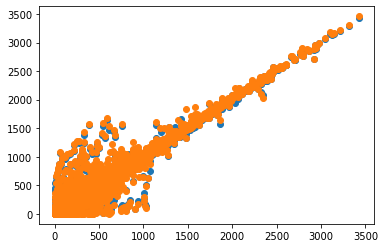

In [34]:
prediction(call_df)

In [36]:
prediction(put_df)

Epoch 1/20
1064/1064 [==============================] - 4s 3ms/step - loss: 46.5493 - mse: 13988.4365 - val_loss: 33.4480 - val_mse: 6525.1909
Epoch 2/20
1064/1064 [==============================] - 4s 4ms/step - loss: 34.1871 - mse: 5767.5063 - val_loss: 30.7590 - val_mse: 6377.6069
Epoch 3/20
1064/1064 [==============================] - 4s 3ms/step - loss: 34.2080 - mse: 5670.4702 - val_loss: 33.7244 - val_mse: 6255.8345
Epoch 4/20
1064/1064 [==============================] - 4s 3ms/step - loss: 32.5301 - mse: 5537.7603 - val_loss: 33.2240 - val_mse: 6016.0947
Epoch 5/20
1064/1064 [==============================] - 4s 3ms/step - loss: 31.9259 - mse: 5445.2236 - val_loss: 32.1951 - val_mse: 6746.2764
Epoch 6/20
1064/1064 [==============================] - 4s 3ms/step - loss: 30.4619 - mse: 5310.6714 - val_loss: 26.7731 - val_mse: 5980.8213
Epoch 7/20
1064/1064 [==============================] - 4s 3ms/step - loss: 30.8329 - mse: 5334.0996 - val_loss: 31.1132 - val_mse: 6370.6465
Epoch